成功读取数据，共 582100 行
总交易次数: 59791
盈利交易次数: 27742
亏损交易次数: 30051
胜率: 46.40%
累计获利: 6712.00 点
累计利润率: 26.30%


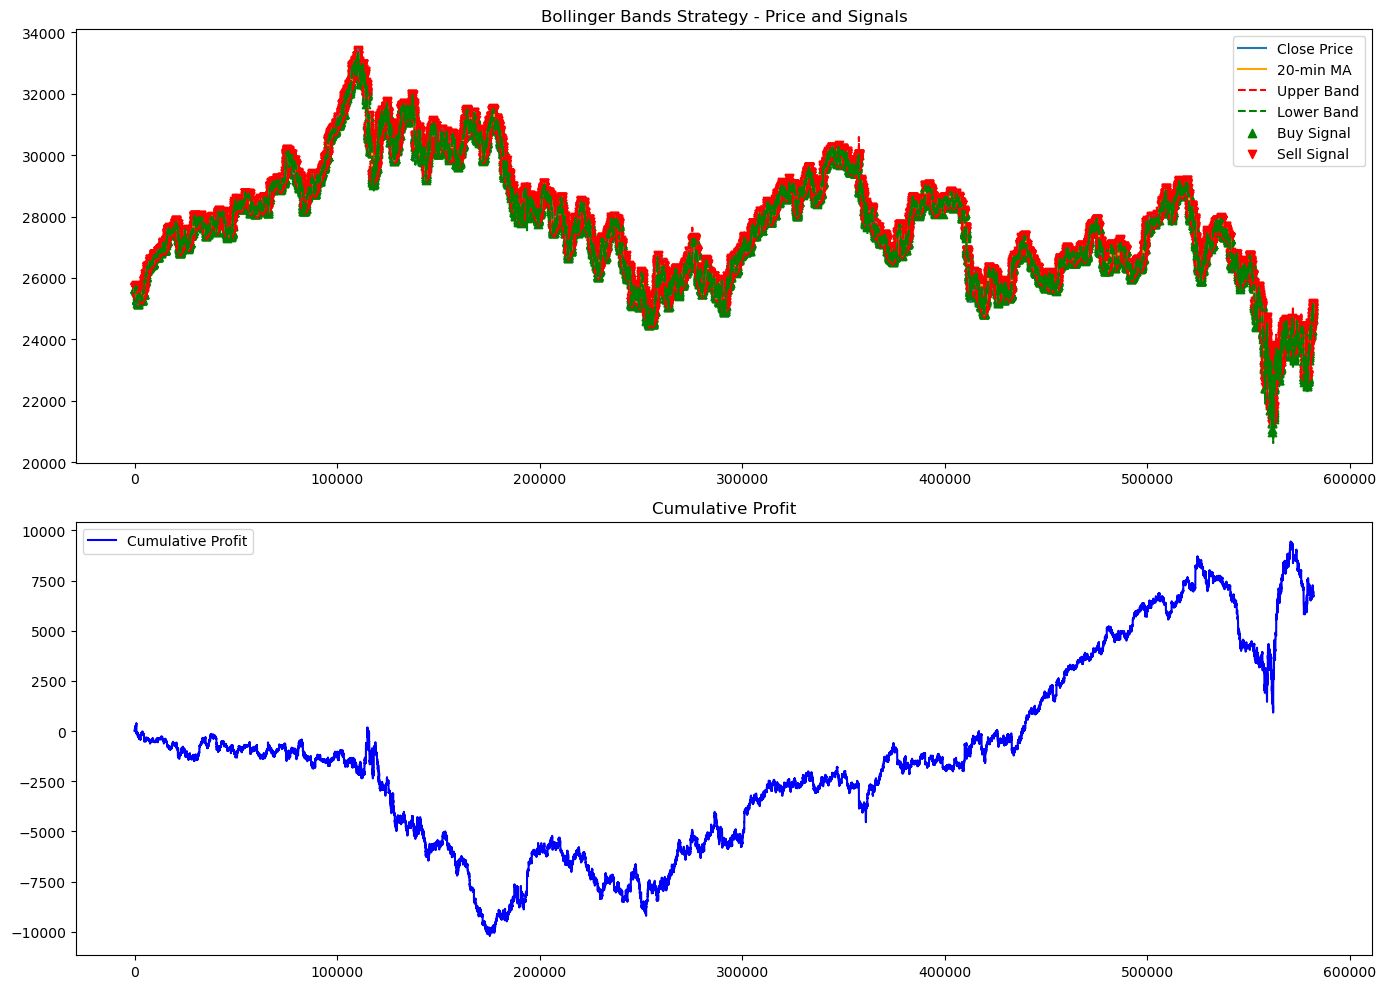

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
def load_data(file_path):
    # 读取CSV文件，假设第一行是列名，后续行按时间顺序递增
    df = pd.read_csv(file_path)
    print(f"成功读取数据，共 {len(df)} 行")
    return df

# 布林格带交易策略
def bollinger_band_strategy(df, window=20, num_std=2):
    """
    实现布林格带交易策略
    
    参数:
    df: 包含OHLCV数据的DataFrame
    window: 计算均值和标准差的窗口大小
    num_std: 标准差的倍数
    
    返回:
    包含交易信号和收益的DataFrame
    """
    # 创建结果DataFrame的副本
    result = df.copy()
    
    # 计算滚动均值和标准差
    result['rolling_mean'] = result['hi1_close'].rolling(window=window).mean()
    result['rolling_std'] = result['hi1_close'].rolling(window=window).std()
    
    # 计算布林带上下轨
    result['upper_band'] = result['rolling_mean'] + (num_std * result['rolling_std'])
    result['lower_band'] = result['rolling_mean'] - (num_std * result['rolling_std'])
    
    # 初始化信号列
    result['signal'] = 0  # 0表示不操作，1表示买入，-1表示卖出
    
    # 生成交易信号 - 修复链式赋值问题
    for i in range(window, len(result)-1):
        # 当前收盘价高于上轨，下一分钟开盘时做空
        if result['hi1_close'].iloc[i] > result['upper_band'].iloc[i]:
            result.loc[i+1, 'signal'] = -1  # 修改为使用.loc
        # 当前收盘价低于下轨，下一分钟开盘时做多
        elif result['hi1_close'].iloc[i] < result['lower_band'].iloc[i]:
            result.loc[i+1, 'signal'] = 1  # 修改为使用.loc
    
    # 计算交易价格
    result['trade_price'] = 0.0
    result.loc[result['signal'] == 1, 'trade_price'] = -result.loc[result['signal'] == 1, 'hi1_close']
    result.loc[result['signal'] == -1, 'trade_price'] = result.loc[result['signal'] == -1, 'hi1_close']
    
    # 计算平仓价格
    result['exit_price'] = 0.0
    
    # 处理每个交易
    current_position = None
    entry_row = None
    
    for i in range(len(result)):
        # 如果当前行有交易信号
        if result['signal'].iloc[i] != 0:
            # 如果已有持仓，先平仓
            if current_position is not None:
                # 计算平仓价格
                exit_price = result['hi1_close'].iloc[i]
                
                # 更新之前交易行的exit_price
                if current_position == 1:  # 多头平仓
                    result.loc[entry_row, 'exit_price'] = exit_price
                else:  # 空头平仓
                    result.loc[entry_row, 'exit_price'] = -exit_price
                
                current_position = None
            
            # 建立新仓位
            current_position = result['signal'].iloc[i]
            entry_row = i
    
    # 处理最后一个未平仓的交易
    if current_position is not None:
        last_price = result['hi1_close'].iloc[-1]
        if current_position == 1:  # 多头平仓
            result.loc[entry_row, 'exit_price'] = last_price
        else:  # 空头平仓
            result.loc[entry_row, 'exit_price'] = -last_price
    
    # 计算每笔交易的收益
    result['profit'] = 0.0
    result.loc[result['signal'] != 0, 'profit'] = result.loc[result['signal'] != 0, 'exit_price'] + result.loc[result['signal'] != 0, 'trade_price']
    
    # 计算累计收益
    result['cumulative_profit'] = result['profit'].cumsum()
    
    # 计算累计利润率 (相对于初始价格)
    initial_price = result['hi1_close'].iloc[0]
    result['profit_rate'] = result['cumulative_profit'] / initial_price * 100
    
    return result

# 主函数
def main():
    # 加载数据
    file_path = 'hi1_20170701_20200609.csv'
    df = load_data(file_path)
    
    # 应用布林格带策略
    result = bollinger_band_strategy(df, window=20, num_std=2)
    
    # 过滤有交易的记录
    trades = result[result['signal'] != 0].copy()
    
    # 输出交易统计信息
    total_trades = len(trades)
    winning_trades = len(trades[trades['profit'] > 0])
    losing_trades = len(trades[trades['profit'] < 0])
    win_rate = winning_trades / total_trades * 100 if total_trades > 0 else 0
    
    final_profit = result['cumulative_profit'].iloc[-1]
    final_profit_rate = result['profit_rate'].iloc[-1]
    
    print(f"总交易次数: {total_trades}")
    print(f"盈利交易次数: {winning_trades}")
    print(f"亏损交易次数: {losing_trades}")
    print(f"胜率: {win_rate:.2f}%")
    print(f"累计获利: {final_profit:.2f} 点")
    print(f"累计利润率: {final_profit_rate:.2f}%")
    
    # 可视化结果
    plt.figure(figsize=(14, 10))
    
    # 绘制价格和布林带
    plt.subplot(2, 1, 1)
    plt.plot(result.index, result['hi1_close'], label='Close Price')
    plt.plot(result.index, result['rolling_mean'], label='20-min MA', color='orange')
    plt.plot(result.index, result['upper_band'], label='Upper Band', color='red', linestyle='--')
    plt.plot(result.index, result['lower_band'], label='Lower Band', color='green', linestyle='--')
    
    # 标记买入和卖出点
    buy_signals = result[result['signal'] == 1]
    sell_signals = result[result['signal'] == -1]
    
    plt.scatter(buy_signals.index, buy_signals['hi1_close'], color='green', marker='^', label='Buy Signal')
    plt.scatter(sell_signals.index, sell_signals['hi1_close'], color='red', marker='v', label='Sell Signal')
    
    plt.title('Bollinger Bands Strategy - Price and Signals')
    plt.legend()
    
    # 绘制累计收益
    plt.subplot(2, 1, 2)
    plt.plot(result.index, result['cumulative_profit'], label='Cumulative Profit', color='blue')
    plt.title('Cumulative Profit')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('bollinger_band_strategy_results.png')
    plt.show()
    
    # 保存交易明细
    trades.to_csv('trades_detail.csv')
    
    # 返回策略结果数据
    return result

if __name__ == "__main__":
    main()


成功读取数据，共 582100 行
总交易次数: 60118
盈利交易次数: 27947
亏损交易次数: 30175
胜率: 46.49%
累计获利: 6890.00 点
累计利润率: 26.99%


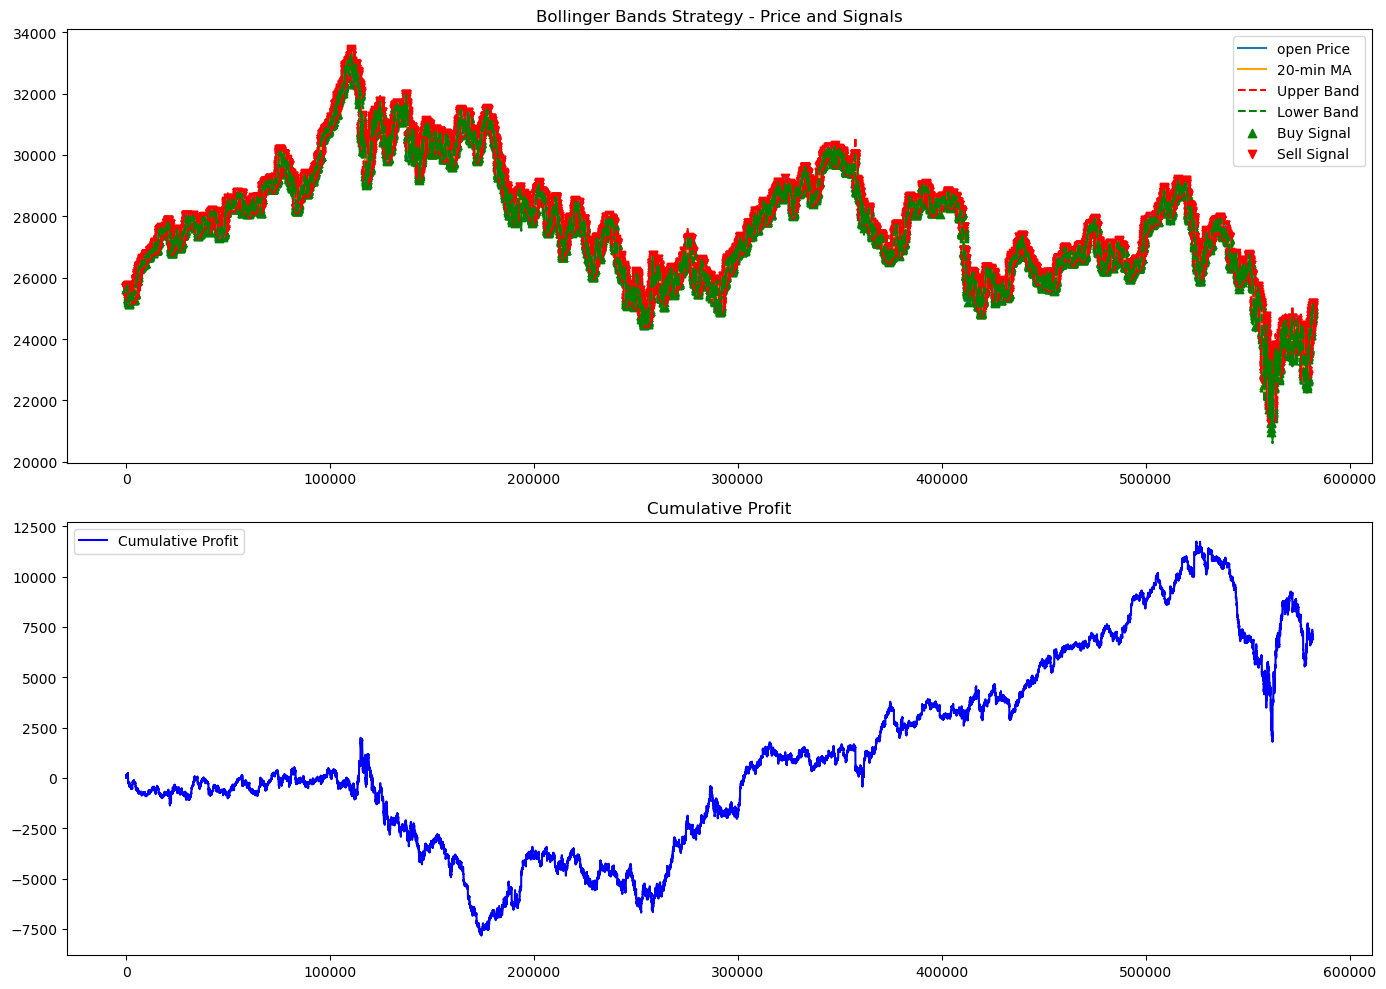

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
def load_data(file_path):
    # 读取CSV文件，假设第一行是列名，后续行按时间顺序递增
    df = pd.read_csv(file_path)
    print(f"成功读取数据，共 {len(df)} 行")
    return df

# 布林格带交易策略
def bollinger_band_strategy(df, window=20, num_std=2):
    """
    实现布林格带交易策略
    
    参数:
    df: 包含OHLCV数据的DataFrame
    window: 计算均值和标准差的窗口大小
    num_std: 标准差的倍数
    
    返回:
    包含交易信号和收益的DataFrame
    """
    # 创建结果DataFrame的副本
    result = df.copy()
    
    # 计算滚动均值和标准差
    result['rolling_mean'] = result['hi1_open'].rolling(window=window).mean()
    result['rolling_std'] = result['hi1_open'].rolling(window=window).std()
    
    # 计算布林带上下轨
    result['upper_band'] = result['rolling_mean'] + (num_std * result['rolling_std'])
    result['lower_band'] = result['rolling_mean'] - (num_std * result['rolling_std'])
    
    # 初始化信号列
    result['signal'] = 0  # 0表示不操作，1表示买入，-1表示卖出
    
    # 生成交易信号 - 修复链式赋值问题
    for i in range(window, len(result)-1):
        # 当前收盘价高于上轨，下一分钟开盘时做空
        if result['hi1_open'].iloc[i] > result['upper_band'].iloc[i]:
            result.loc[i+1, 'signal'] = -1  # 修改为使用.loc
        # 当前收盘价低于下轨，下一分钟开盘时做多
        elif result['hi1_open'].iloc[i] < result['lower_band'].iloc[i]:
            result.loc[i+1, 'signal'] = 1  # 修改为使用.loc
    
    # 计算交易价格
    result['trade_price'] = 0.0
    result.loc[result['signal'] == 1, 'trade_price'] = -result.loc[result['signal'] == 1, 'hi1_open']
    result.loc[result['signal'] == -1, 'trade_price'] = result.loc[result['signal'] == -1, 'hi1_open']
    
    # 计算平仓价格
    result['exit_price'] = 0.0
    
    # 处理每个交易
    current_position = None
    entry_row = None
    
    for i in range(len(result)):
        # 如果当前行有交易信号
        if result['signal'].iloc[i] != 0:
            # 如果已有持仓，先平仓
            if current_position is not None:
                # 计算平仓价格
                exit_price = result['hi1_open'].iloc[i]
                
                # 更新之前交易行的exit_price
                if current_position == 1:  # 多头平仓
                    result.loc[entry_row, 'exit_price'] = exit_price
                else:  # 空头平仓
                    result.loc[entry_row, 'exit_price'] = -exit_price
                
                current_position = None
            
            # 建立新仓位
            current_position = result['signal'].iloc[i]
            entry_row = i
    
    # 处理最后一个未平仓的交易
    if current_position is not None:
        last_price = result['hi1_open'].iloc[-1]
        if current_position == 1:  # 多头平仓
            result.loc[entry_row, 'exit_price'] = last_price
        else:  # 空头平仓
            result.loc[entry_row, 'exit_price'] = -last_price
    
    # 计算每笔交易的收益
    result['profit'] = 0.0
    result.loc[result['signal'] != 0, 'profit'] = result.loc[result['signal'] != 0, 'exit_price'] + result.loc[result['signal'] != 0, 'trade_price']
    
    # 计算累计收益
    result['cumulative_profit'] = result['profit'].cumsum()
    
    # 计算累计利润率 (相对于初始价格)
    initial_price = result['hi1_open'].iloc[0]
    result['profit_rate'] = result['cumulative_profit'] / initial_price * 100
    
    return result

# 主函数
def main():
    # 加载数据
    file_path = 'hi1_20170701_20200609.csv'
    df = load_data(file_path)
    
    # 应用布林格带策略
    result = bollinger_band_strategy(df, window=20, num_std=2)
    
    # 过滤有交易的记录
    trades = result[result['signal'] != 0].copy()
    
    # 输出交易统计信息
    total_trades = len(trades)
    winning_trades = len(trades[trades['profit'] > 0])
    losing_trades = len(trades[trades['profit'] < 0])
    win_rate = winning_trades / total_trades * 100 if total_trades > 0 else 0
    
    final_profit = result['cumulative_profit'].iloc[-1]
    final_profit_rate = result['profit_rate'].iloc[-1]
    
    print(f"总交易次数: {total_trades}")
    print(f"盈利交易次数: {winning_trades}")
    print(f"亏损交易次数: {losing_trades}")
    print(f"胜率: {win_rate:.2f}%")
    print(f"累计获利: {final_profit:.2f} 点")
    print(f"累计利润率: {final_profit_rate:.2f}%")
    
    # 可视化结果
    plt.figure(figsize=(14, 10))
    
    # 绘制价格和布林带
    plt.subplot(2, 1, 1)
    plt.plot(result.index, result['hi1_open'], label='open Price')
    plt.plot(result.index, result['rolling_mean'], label='20-min MA', color='orange')
    plt.plot(result.index, result['upper_band'], label='Upper Band', color='red', linestyle='--')
    plt.plot(result.index, result['lower_band'], label='Lower Band', color='green', linestyle='--')
    
    # 标记买入和卖出点
    buy_signals = result[result['signal'] == 1]
    sell_signals = result[result['signal'] == -1]
    
    plt.scatter(buy_signals.index, buy_signals['hi1_open'], color='green', marker='^', label='Buy Signal')
    plt.scatter(sell_signals.index, sell_signals['hi1_open'], color='red', marker='v', label='Sell Signal')
    
    plt.title('Bollinger Bands Strategy - Price and Signals')
    plt.legend()
    
    # 绘制累计收益
    plt.subplot(2, 1, 2)
    plt.plot(result.index, result['cumulative_profit'], label='Cumulative Profit', color='blue')
    plt.title('Cumulative Profit')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('bollinger_band_strategy_results.png')
    plt.show()
    
    # 保存交易明细
    trades.to_csv('trades_detail.csv')
    
    # 返回策略结果数据
    return result

if __name__ == "__main__":
    main()
